In [1]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

In [2]:
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

In [3]:
import glob
import os
import rasterio

In [4]:
train_nir="D:/Acres/January 2025/Assignment 8/AgriculturalField-Seg/train/original_train"
train_mask="D:/Acres/January 2025/Assignment 8/AgriculturalField-Seg/train/groundtruth_train"

In [27]:
def load_data(image_dir, mask_dir, image_size=(256, 256)):
    """Load images and masks, resize them, and normalize."""
    images = []
    masks = []
    
    # Load images
    for img_file in sorted(os.listdir(image_dir)):
        img_path = os.path.join(image_dir, img_file)
        img = tf.keras.utils.load_img(img_path, target_size=image_size)
        img = tf.keras.utils.img_to_array(img) / 255  # Normalize to [0, 1]
        images.append(img)
    
    # Load masks
    for mask_file in sorted(os.listdir(mask_dir)):
        mask_path = os.path.join(mask_dir, mask_file)
        mask = tf.keras.utils.load_img(mask_path, target_size=image_size, color_mode="grayscale")
        mask = tf.keras.utils.img_to_array(mask)
        mask = mask / 255  # Normalize mask to [0, 1]
        mask = np.squeeze(mask)  # Remove single channel
        mask = mask.astype(int)  # Convert mask to integer type
        mask = to_categorical(mask, num_classes=2)  # Convert to one-hot encoding
        masks.append(mask)
    
    return np.array(images), np.array(masks)


In [29]:
# Define DeepLabV3+ model
def create_deeplabv3plus(input_shape=(256, 256, 3), num_classes=2):
    """Build a DeepLabV3+ model."""
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False)
    base_model.trainable = False  # Freeze base model during initial training
    
    # Extract features at different layers
    x = base_model.get_layer("block_13_expand_relu").output  # High-level features
    x = tf.keras.layers.Conv2D(256, (1, 1), activation="relu")(x)
    
    low_level_features = base_model.get_layer("block_3_expand_relu").output
    low_level_features = tf.keras.layers.Conv2D(48, (1, 1), activation="relu")(low_level_features)
    
    # Upsample and concatenate
    x = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)
    x = tf.keras.layers.Concatenate()([x, low_level_features])
    x = tf.keras.layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)
    0
    # Final output layer
    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation="softmax")(x)
    
    return tf.keras.Model(inputs=base_model.input, outputs=outputs)



In [35]:
def create_deeplabv3plus(input_shape=(256, 256, 3), num_classes=2):
    """Build a DeepLabV3+ model with additional edge detection filters, convolution layers, and max pooling layers."""
    # Base model: MobileNetV2
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False)
    base_model.trainable = False  # Freeze base model during initial training

    # Extract high-level features
    high_level_features = base_model.get_layer("block_13_expand_relu").output
    high_level_features = tf.keras.layers.Conv2D(256, (1, 1), activation="relu")(high_level_features)

    # Add multiple edge detection filters
    edge_detection_filters = tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu")(high_level_features)
    edge_detection_filters = tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu")(edge_detection_filters)

    # Add max pooling for feature refinement
    edge_detection_filters = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(edge_detection_filters)

    # Add additional convolutional layers for feature extraction
    x = tf.keras.layers.Conv2D(128, (3, 3), padding="same", activation="relu")(edge_detection_filters)
    x = tf.keras.layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)

    # Extract low-level features
    low_level_features = base_model.get_layer("block_3_expand_relu").output
    low_level_features = tf.keras.layers.Conv2D(48, (1, 1), activation="relu")(low_level_features)

    # Upsample high-level features to match low-level features' spatial dimensions
    x = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(x)

    # Concatenate high-level and low-level features
    x = tf.keras.layers.Concatenate()([x, low_level_features])

    # Add additional convolution layers after concatenation
    x = tf.keras.layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)

    # Upsample to match the input resolution
    x = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)

    # Final output layer
    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation="softmax")(x)

    return tf.keras.Model(inputs=base_model.input, outputs=outputs)

# Example usage
model = create_deeplabv3plus(input_shape=(256, 256, 3), num_classes=2)
model.summary()


C:\Users\Admin\AppData\Local\Temp\ipykernel_13212\1144298664.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False)


ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 16, 16, 128), (None, 64, 64, 48)]

In [30]:
# Compile and train the model
def train_model():
    # Replace paths with your directories
    train_nir = "D:/Acres/January 2025/Assignment 8/AgriculturalField-Seg/train/original_train"
    train_mask = "D:/Acres/January 2025/Assignment 8/AgriculturalField-Seg/train/groundtruth_train"
    
    # Load dataset
    X, Y = load_data(train_nir, train_mask)
    
    # Split into train and validation sets
    split_idx = int(0.8 * len(X))
    X_train, X_val = X[:split_idx], X[split_idx:]
    Y_train, Y_val = Y[:split_idx], Y[split_idx:]
    
    # Create model
    model = create_deeplabv3plus(input_shape=(256, 256, 3), num_classes=2)
    
    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    
    # Train model
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        batch_size=16,
        epochs=5
    )
    
    return model, history


In [31]:
# Run training
if __name__ == "__main__":
    model, history = train_model()
    
    # Save the model
    model.save("deeplabv3plus_bund_segmentation.h5")
    
    # Plot training history
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_13212\3119495921.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False)


Epoch 1/5
 2/46 ━━━━━━━━━━━━━━━━━━━━ 4:26 6s/step - accuracy: 0.9294 - loss: 0.5285 

KeyboardInterrupt: 

29/29 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step


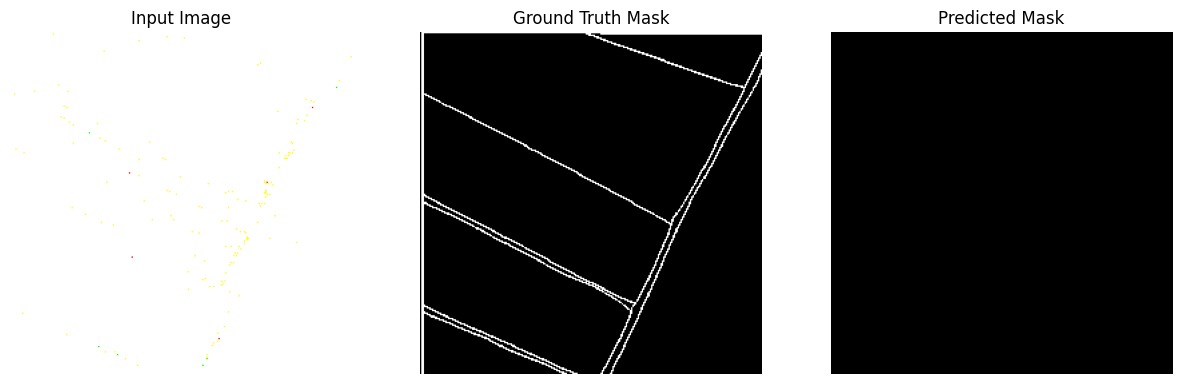

In [16]:
import matplotlib.pyplot as plt

def visualize_prediction(image, true_mask, pred_mask, image_index=0):
    """
    Visualize input image, ground truth mask, and predicted mask side-by-side.

    Parameters:
        image: Array of input images.
        true_mask: Array of ground truth masks.
        pred_mask: Array of predicted masks.
        image_index: Index of the image to visualize.
    """
    # Retrieve the specific image, ground truth mask, and predicted mask
    img = image[image_index]
    true_msk = true_mask[image_index]
    pred_msk = pred_mask[image_index]
    
    # Ensure masks are argmax-ed if in one-hot format
    if true_msk.ndim == 3:
        true_msk = true_msk.argmax(axis=-1)
    if pred_msk.ndim == 3:
        pred_msk = pred_msk.argmax(axis=-1)
    
    # Plot the images
    plt.figure(figsize=(15, 5))
    
    # Display the input image
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis("off")
    
    # Display the true mask
    plt.subplot(1, 3, 2)
    plt.imshow(true_msk, cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")
    
    # Display the predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(pred_msk, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")
    
    plt.show()

# Example usage
if __name__ == "__main__":
    # Example prediction (replace this with your trained model's predictions)
    X, Y = load_data(train_nir, train_mask)  # Load data
    #model, _ = train_model()  # Train your model
    predictions = model.predict(X)  # Predict
    
    # Visualize the first image, ground truth mask, and predicted mask
    visualize_prediction(X, Y, predictions, image_index=0)


29/29 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step


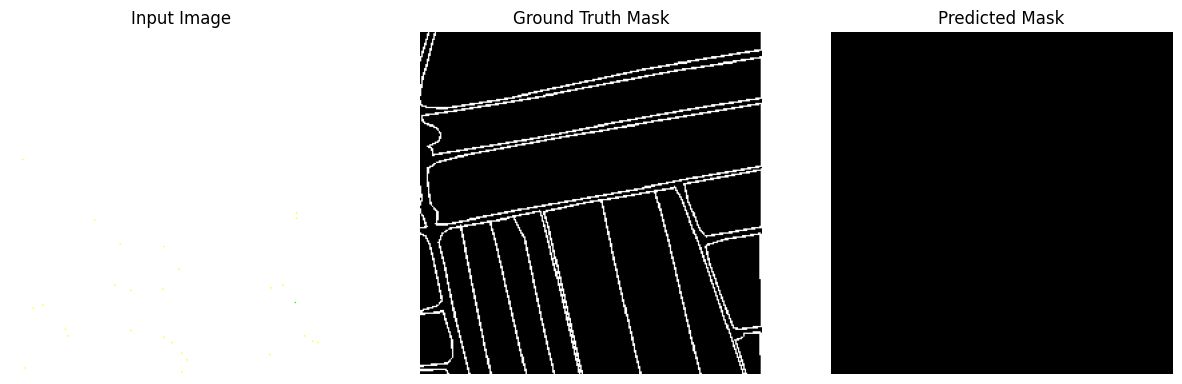

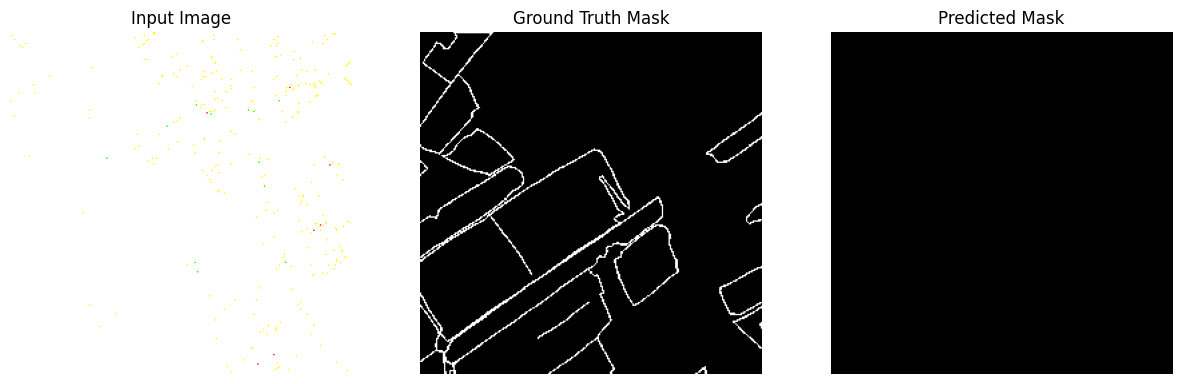

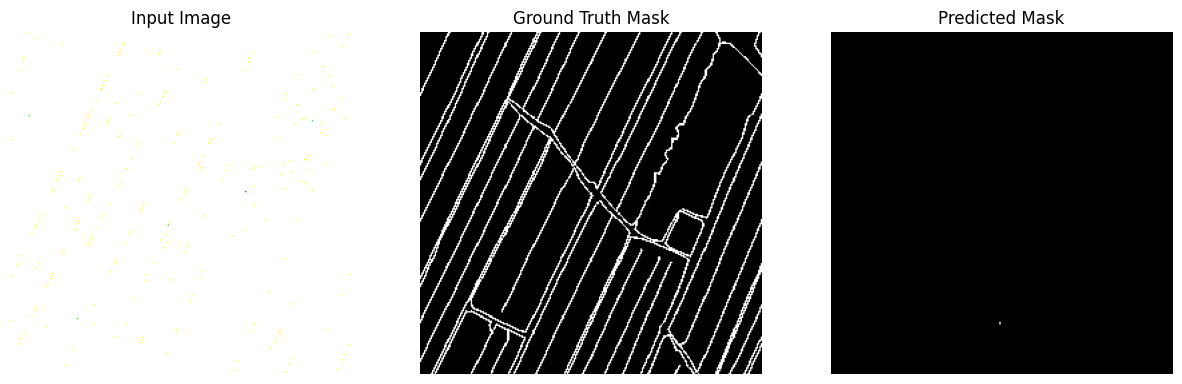

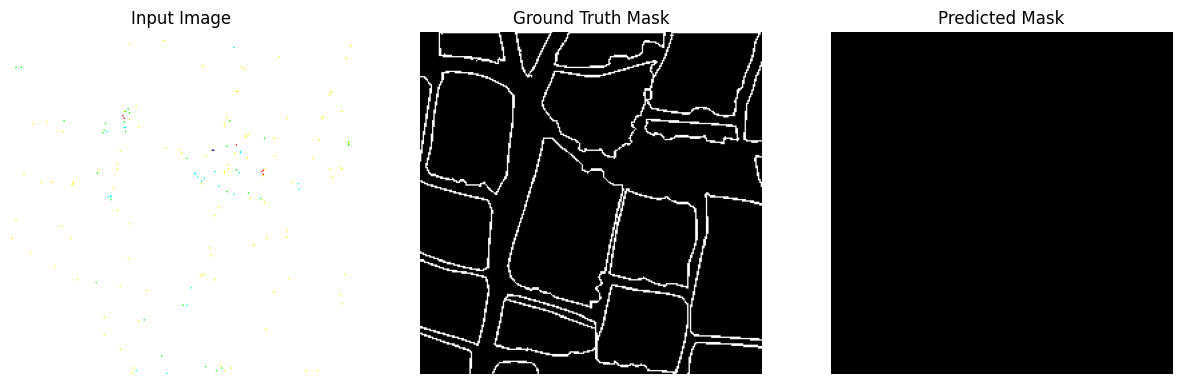

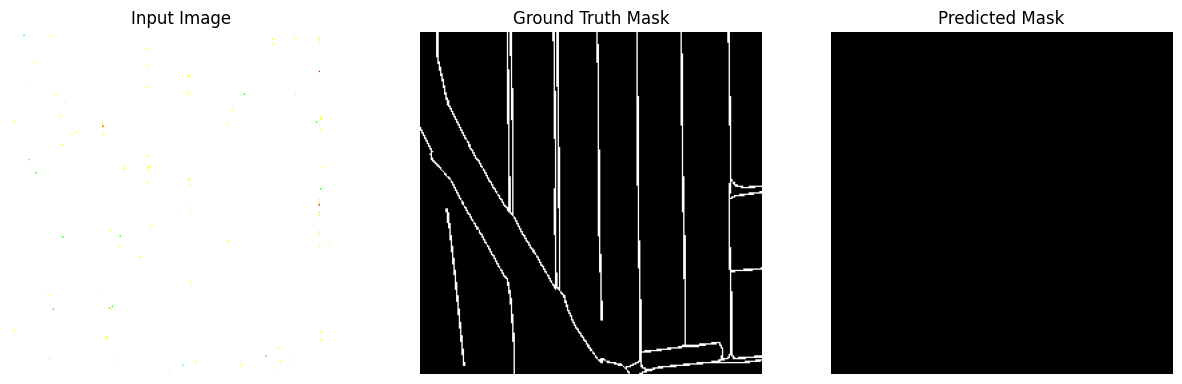

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_prediction(image, true_mask, pred_mask, image_index):
    """
    Visualize input image, ground truth mask, and predicted mask side-by-side.

    Parameters:
        image: Array of input images.
        true_mask: Array of ground truth masks.
        pred_mask: Array of predicted masks.
        image_index: Index of the image to visualize.
    """
    # Retrieve the specific image, ground truth mask, and predicted mask
    img = image[image_index]
    true_msk = true_mask[image_index]
    pred_msk = pred_mask[image_index]
    
    # Ensure masks are argmax-ed if in one-hot format
    if true_msk.ndim == 3:
        true_msk = true_msk.argmax(axis=-1)
    if pred_msk.ndim == 3:
        pred_msk = pred_msk.argmax(axis=-1)
    
    # Plot the images
    plt.figure(figsize=(15, 5))
    
    # Display the input image
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis("off")
    
    # Display the true mask
    plt.subplot(1, 3, 2)
    plt.imshow(true_msk, cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")
    
    # Display the predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(pred_msk, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")
    
    plt.show()

# Example usage
if __name__ == "__main__":
    # Replace with actual data loading
    X, Y = load_data(train_nir, train_mask)  # Load data
    predictions = model.predict(X)  # Predict masks with your trained model

    # Select 5 random indices
    random_indices = np.random.choice(X.shape[0], 5, replace=False)

    # Visualize predictions for the 5 random images
    for idx in random_indices:
        visualize_prediction(X, Y, predictions, image_index=idx)
